In [37]:
# Importing some common libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For statistical tests
import scipy.stats as stats

# For spilliting the data and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For sampling
from imblearn.over_sampling import SMOTE

# for model building
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# For evaluation
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.metrics import recall_score,precision_score

# About the Data
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

Please cite the following works:

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019

Yann-Aël Le Borgne, Gianluca Bontempi Reproducible machine Learning for Credit Card Fraud Detection - Practical Handbook

Bertrand Lebichot, Gianmarco Paldino, Wissam Siblini, Liyun He, Frederic Oblé, Gianluca Bontempi Incremental learning strategies for credit cards fraud detection, IInternational Journal of Data Science and Analytics

Source: https://www.kaggle.com/datasets/whenamancodes/fraud-detection

# Data Reading and basic eyeballing

In [2]:
# Reading the data
df=pd.read_csv('creditcard.csv')

In [3]:
# First five rows
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# shape of the data
df.shape

(284807, 31)

In [5]:
# Info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# Checking for missing values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
# Data has no missing values

In [8]:
# Checking for imbalance of the target variable
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

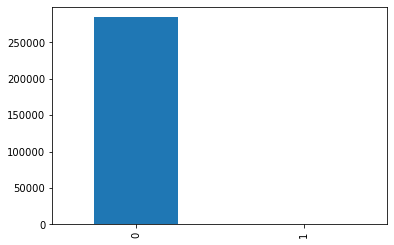

In [9]:
df.Class.value_counts().plot.bar()
plt.show()

In [10]:
# We see that the target variable is highly imbalanced. We may have to imply oversampling techniques to counter this

In [11]:
# Since the data is masked, doing exploratory Data Analysis wouldn't make sense

In [12]:
# We will go ahead with feature selection

In [13]:
# Distribution of the variables

# Feature Selection

In [14]:
# Taking significance level at 0.05

stat_df=pd.DataFrame() # making an empty dataframe to store name of feature and pvalue
stat_df['Feature']=df.drop(columns='Class').columns
pvalue=[]

for i in df.drop(columns='Class').columns:
    # Null Hypothesis: 'i' has no impact on the target variable
    # Alternate Hypothesis: 'i' has an impact on the target variable
    class_1=df.loc[df.Class==1,i]
    class_0=df.loc[df.Class==0,i]
    pvalue.append(stats.ttest_ind(class_1,class_0)[1])

stat_df['Pvalue']=pvalue

In [15]:
selected_features=stat_df.loc[stat_df.Pvalue<0.05]['Feature'].values

# Base Model

In [16]:
# We will proceed with a base model of linear regression

# Splitting the data
x=df[selected_features]
y=df.Class
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,stratify=y)

In [17]:
x_train.shape,x_test.shape

((199364, 27), (85443, 27))

In [18]:
# Scaling the data
sc=StandardScaler()
x_train_s=pd.DataFrame(sc.fit_transform(x_train),columns=x_train.columns)
x_test_s=pd.DataFrame(sc.transform(x_test),columns=x_test.columns)

In [19]:
# Adding constant column in x_train and x_test
x_train_s=sm.add_constant(x_train_s)
x_test_s=sm.add_constant(x_test_s)

In [20]:
y_train=y_train.reset_index().drop(columns='index')
y_test=y_test.reset_index().drop(columns='index')

In [21]:
# before model bulding we will build an evaluation function

def evaluation(y_test,y_pred):
    
    print('Accuracy Score:',accuracy_score(y_test,y_pred))
    print('f1_score:',f1_score(y_test,y_pred))
    print('Precision:',precision_score(y_test,y_pred))
    print('Recall:',recall_score(y_test,y_pred))
    print('Classification report:\n',classification_report(y_test,y_pred))
    cm=confusion_matrix(y_test,y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title('Confusion matrix for the given prediction')
    plt.show()
    
# Our evaluation fucntion is now created

In [22]:
# Fitting a model
base_model=sm.Logit(y_train,x_train_s).fit()
y_pred_proba=base_model.predict(x_test_s)

Optimization terminated successfully.
         Current function value: 0.003634
         Iterations 14


In [23]:
# Summary of the model
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:               199364
Model:                          Logit   Df Residuals:                   199336
Method:                           MLE   Df Model:                           27
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                  0.7139
Time:                        12:58:06   Log-Likelihood:                -724.43
converged:                       True   LL-Null:                       -2532.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7094      0.190    -45.885      0.000      -9.081      -8.337
Time          -0.1500      0.125     -1.196      0.232      -0.396       0.096
V1             0.2017      0.107      1.880      0.060      -0.009       0.412
V2             0.1025      0.142      0.720      0.471      -0.177       0.382
V3             0.1149      0.105      1.098      0.272      -0.090       0.320
V4             1.0506      0.149      7.034      0.000       0.758       1.343
V5             0.2341      0.125      1.875      0.061      -0.011       0.479
V6            -0.1271      0.125     -1.015      0.310      -0.373       0.118
V7            -0.0974      0.113     -0.860      0.390      -0.319       0.125
V8            -0.2320      0.050     -4.645      0.000      -0.330      -0.134
V9            -0.1958      0.164     -1.191      0.234      -0.518       0.126
V10           -0.9274      0.144     -6.445      0.000      -1.209      -0.645
V11           -0.0251      0.102     -0.245      0.806      -0.226       0.176
V12            0.0526      0.118      0.448      0.654      -0.178       0.283
V13           -0.3567      0.099     -3.614      0.000      -0.550      -0.163
V14           -0.5083      0.078     -6.534      0.000      -0.661      -0.356
V15           -0.0576      0.100     -0.577      0.564      -0.253       0.138
V16           -0.3202      0.129     -2.489      0.013      -0.572      -0.068
V17           -0.1446      0.079     -1.819      0.069      -0.300       0.011
V18            0.0866      0.133      0.652      0.514      -0.174       0.347
V19            0.0032      0.100      0.033      0.974      -0.192       0.198
V20           -0.3939      0.084     -4.663      0.000      -0.560      -0.228
V21            0.1092      0.042      2.577      0.010       0.026       0.192
V24            0.0691      0.113      0.612      0.541      -0.152       0.290
V26           -0.0035      0.113     -0.031      0.975      -0.225       0.218
V27           -0.3908      0.064     -6.130      0.000      -0.516      -0.266
V28           -0.1473      0.047     -3.141      0.002      -0.239      -0.055
Amount         0.2810      0.136      2.068      0.039       0.015       0.547
==============================================================================

Possibly complete quasi-separation: A fraction 0.30 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [24]:
y_pred=[]

# Taking threshold for probability at 0.5
for i in y_pred_proba:
    if i>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

Accuracy Score: 0.9991222218320986
f1_score: 0.7058823529411764
Precision: 0.8411214953271028
Recall: 0.6081081081081081
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.84      0.61      0.71       148

    accuracy                           1.00     85443
   macro avg       0.92      0.80      0.85     85443
weighted avg       1.00      1.00      1.00     85443



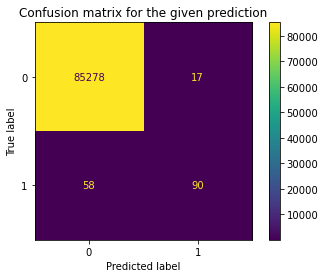

In [25]:
# Evaluating the model
evaluation(y_test,y_pred)

#### We observe that we get an excellent accuracy score of 99.9% but a poor recall score. This due to the high imbalance in the target class. We will try some oversampling techniques to see if we can counter this.

# SMOTE

In [26]:
x_train_sampled,y_train_sampled=SMOTE().fit_resample(x_train_s,y_train)

In [27]:
# we now have an oversampled training set
# We will apply the Logistic regression model again

In [28]:
model=sm.Logit(y_train_sampled,x_train_sampled).fit()
y_pred_proba=model.predict(x_test_s)

Optimization terminated successfully.
         Current function value: 0.138634
         Iterations 14


In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:               398040
Model:                          Logit   Df Residuals:                   398012
Method:                           MLE   Df Model:                           27
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                  0.8000
Time:                        12:58:09   Log-Likelihood:                -55182.
converged:                       True   LL-Null:                   -2.7590e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5375      0.017   -214.171      0.000      -3.570      -3.505
Time          -0.4348      0.012    -37.241      0.000      -0.458      -0.412
V1             0.9318      0.021     45.240      0.000       0.891       0.972
V2             0.2123      0.020     10.365      0.000       0.172       0.252
V3             0.2718      0.012     21.852      0.000       0.247       0.296
V4             1.3106      0.013    104.798      0.000       1.286       1.335
V5             0.6947      0.013     54.962      0.000       0.670       0.719
V6            -0.3390      0.012    -29.182      0.000      -0.362      -0.316
V7             0.0402      0.012      3.429      0.001       0.017       0.063
V8            -0.6457      0.012    -55.540      0.000      -0.669      -0.623
V9            -0.2590      0.015    -17.675      0.000      -0.288      -0.230
V10           -0.9970      0.019    -52.164      0.000      -1.034      -0.960
V11            0.6655      0.012     55.941      0.000       0.642       0.689
V12           -0.8331      0.017    -48.914      0.000      -0.866      -0.800
V13           -0.4379      0.008    -53.899      0.000      -0.454      -0.422
V14           -1.3142      0.017    -75.974      0.000      -1.348      -1.280
V15           -0.0166      0.008     -2.027      0.043      -0.033      -0.001
V16           -0.8383      0.015    -57.755      0.000      -0.867      -0.810
V17           -0.8747      0.020    -44.495      0.000      -0.913      -0.836
V18           -0.0425      0.012     -3.563      0.000      -0.066      -0.019
V19            0.1032      0.009     11.258      0.000       0.085       0.121
V20           -0.2773      0.013    -21.454      0.000      -0.303      -0.252
V21            0.0352      0.008      4.399      0.000       0.020       0.051
V24            0.0147      0.010      1.512      0.131      -0.004       0.034
V26           -0.1686      0.010    -16.593      0.000      -0.189      -0.149
V27            0.3577      0.013     26.818      0.000       0.332       0.384
V28            0.1783      0.012     15.199      0.000       0.155       0.201
Amount         0.8140      0.023     34.681      0.000       0.768       0.860
==============================================================================

Possibly complete quasi-separation: A fraction 0.42 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [30]:
y_pred=[]

# Taking threshold for probability at 0.5
for i in y_pred_proba:
    if i>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

Accuracy Score: 0.978792879463502
f1_score: 0.12800769971126086
Precision: 0.0689119170984456
Recall: 0.8986486486486487
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.90      0.13       148

    accuracy                           0.98     85443
   macro avg       0.53      0.94      0.56     85443
weighted avg       1.00      0.98      0.99     85443



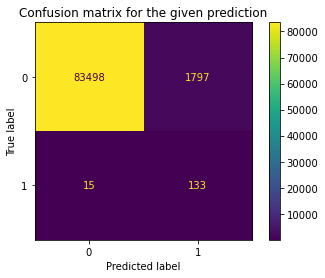

In [31]:
# Evaluation of the model
evaluation(y_test,y_pred)

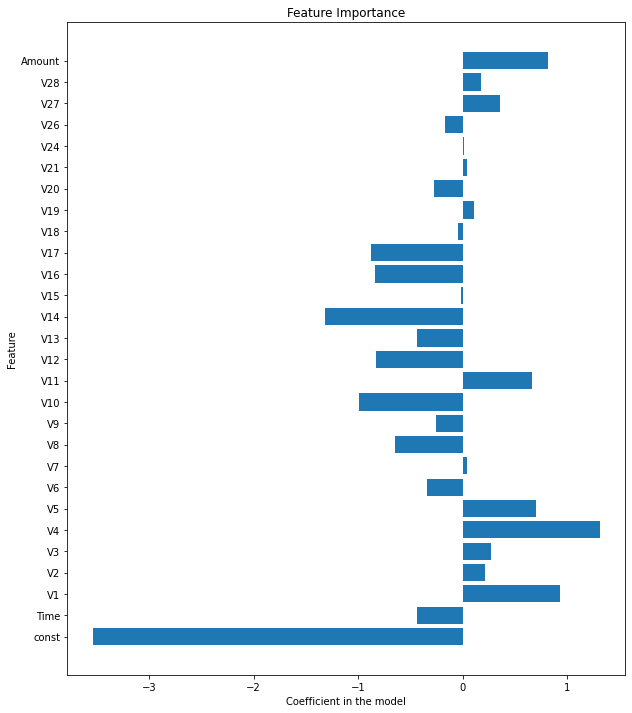

In [60]:
plt.rcParams['figure.figsize']=[10,12]
plt.barh(y=model.params.index,width=model.params.values)
plt.title('Feature Importance')
plt.ylabel('Feature')
plt.xlabel('Coefficient in the model')
plt.show()

#### We observe that our recall score has imporved considerably in case of a Logistic Regression model. We will further see whether our model could improve through some tree based models.

# Decision Tree

In [32]:
# Since we are using decision tree we won't be needing to scale the split

In [33]:
# We will usie smote to resample the data again
x_train_sampled,y_train_sampled=SMOTE().fit_resample(x_train,y_train)

In [34]:
dtree=DecisionTreeClassifier(max_depth=5)
dt_model=dtree.fit(x_train_sampled,y_train_sampled)
y_pred=dt_model.predict(x_test)

Accuracy Score: 0.9886825134885245
f1_score: 0.20932134096484056
Precision: 0.11906976744186047
Recall: 0.8648648648648649
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.12      0.86      0.21       148

    accuracy                           0.99     85443
   macro avg       0.56      0.93      0.60     85443
weighted avg       1.00      0.99      0.99     85443



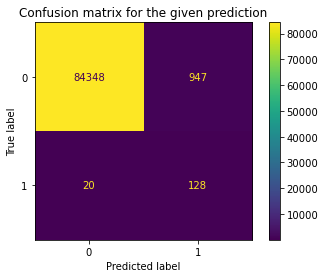

In [35]:
# Evaluating the model
evaluation(y_test,y_pred)

#### We observe that Decision Tree performs worse than Losgistic Regression. We will now see whether bossting methods actually have a positive effect on the oversampled train data.

# Boosting

In [36]:
# For the boosting technique we will use the lightgbm framework

In [38]:
lgbm=LGBMClassifier() # Going with default parameters
lg_model=lgbm.fit(x_train_sampled,y_train_sampled)
y_pred=lg_model.predict(x_test)

Accuracy Score: 0.9990871107053826
f1_score: 0.7547169811320755
Precision: 0.7058823529411765
Recall: 0.8108108108108109
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.71      0.81      0.75       148

    accuracy                           1.00     85443
   macro avg       0.85      0.91      0.88     85443
weighted avg       1.00      1.00      1.00     85443



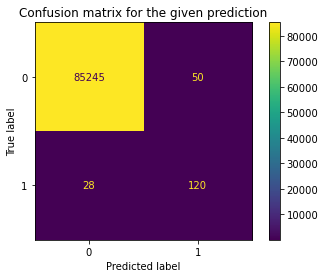

In [39]:
# Model evaluation
evaluation(y_test,y_pred)

#### We observe that the lightgbm model is performing poorly compared to Decision Tree in terms of recall score, but has a much better f1-score. Let us see whether we can improve the performance of the lightgbm model by increasing the weight of the positive class

In [46]:
lgbm=LGBMClassifier(scale_pos_weight=100)
lg_model=lgbm.fit(x_train_sampled,y_train_sampled)
y_pred=lg_model.predict(x_test)

Accuracy Score: 0.996278220568098
f1_score: 0.4381625441696113
Precision: 0.2966507177033493
Recall: 0.8378378378378378
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.30      0.84      0.44       148

    accuracy                           1.00     85443
   macro avg       0.65      0.92      0.72     85443
weighted avg       1.00      1.00      1.00     85443



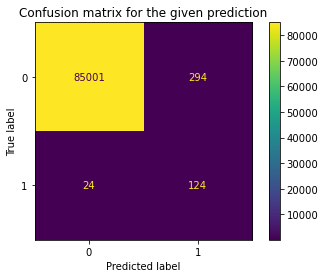

In [48]:
# Model evaluation
evaluation(y_test,y_pred)

#### We observe that Lightgbm still doesn't have a better recall score than logistic regression or Decision tree, even with providing a higher weightage to the positive class. Out of all the models we tried so far, Logistic Regression seems to be working the best.

# Conclusion
* Out of all the models we saw that Logistic Regression worked the best for us in terms of recall score, though the model had a lot of false positives.
* The best method to solve the given problem was applying an oversampling technique(SMOTE) and then applying Logistic regression.
* Tree based models seem to be giving a good f1-score but a poor recall score comparitively
* Boosting methods seem to be performing the best in terms of having the least amount of false positives.